# Signal to Spectrogram Consistency

The purpose of this notebook is to compare the spectrogram and signal to check for consistency.

## Align Spectrogram to Signal

First, we align the spectrogram to the signal and check if the alignment makes sense.

In [1]:
%matplotlib inline

import re
import sys
import random

# Setup the "PYTHONPATH"
sys.path.insert(0, '../../')

In [2]:
from src.audio import read_audio
from src.hparams import set_hparams

set_hparams()

clip = '../../tests/_test_data/lj_speech_24000.wav'
sample_rate = 24000 
signal = read_audio(clip, sample_rate)

Skipping configurable checks for `src.visualize.CometML.<locals>`, this cannot import `<locals>`.


In [4]:
import numpy as np

from src.audio import get_log_mel_spectrogram

frame_size = 1200  # Size of the frame used for stft
frame_hop = 300  # Frame home to be used with stft

signal = signal[0:frame_hop*120] # Arbitrary cut off to ensure the signal is not too large
log_mel_spectrogram, padding = get_log_mel_spectrogram(
    signal, sample_rate, frame_size=frame_size, frame_hop=frame_hop)

# Pad signal such that ``padded_signal.shape[0] / log_mel_spectrogram.shape[0] == frame_hop``
padded_signal = np.pad(signal, padding, mode='constant', constant_values=0)
padded_signal = (1 / np.max(np.abs(padded_signal))) * padded_signal # Scale the signal for a pretty visualization

assert padded_signal.shape[0] / log_mel_spectrogram.shape[0] == frame_hop

(150, 150)
(300, 300)


In [41]:
from matplotlib import pyplot
import librosa

def plot_log_mel_spectrogram(log_mel_spectrogram, 
                             lower_hertz=125,
                             upper_hertz=7600,
                             grid_offset=3):
    """ Get image of log mel spectrogram.
    
    Args:
        grid_offset (int): Offset the grid by ``grid_offset`` frame hops.
    """
    data = log_mel_spectrogram.transpose()
    data = np.exp(data)
    librosa.display.specshow(
        librosa.power_to_db(data, ref=np.max),
        hop_length=frame_hop,
        sr=sample_rate,
        fmin=lower_hertz,
        fmax=upper_hertz,
        cmap='viridis',
        y_axis='mel',
        x_axis='time',
        zorder=1,
    )
    pyplot.grid(True, linestyle='-', linewidth=1, zorder=10, axis='both')
    pyplot.xticks(np.arange((frame_hop / sample_rate) * grid_offset, len(signal) / sample_rate,
                            step=frame_size / sample_rate), rotation='vertical')
    
def plot_waveform(signal, grid_offset=3):
    """ Save image of spectrogram to disk.
    
    Args:
        grid_offset (int): Offset the grid by ``grid_offset`` frame hops.
    """
    librosa.display.waveplot(signal, sr=sample_rate)
    pyplot.grid(True, linestyle='-', linewidth=1, zorder=10, axis='x')
    pyplot.xticks(np.arange((frame_hop / sample_rate) * grid_offset, len(signal) / sample_rate,
                            step=frame_size / sample_rate), rotation='vertical')
    pyplot.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    pyplot.xlabel('')
    pyplot.ylabel('Energy')


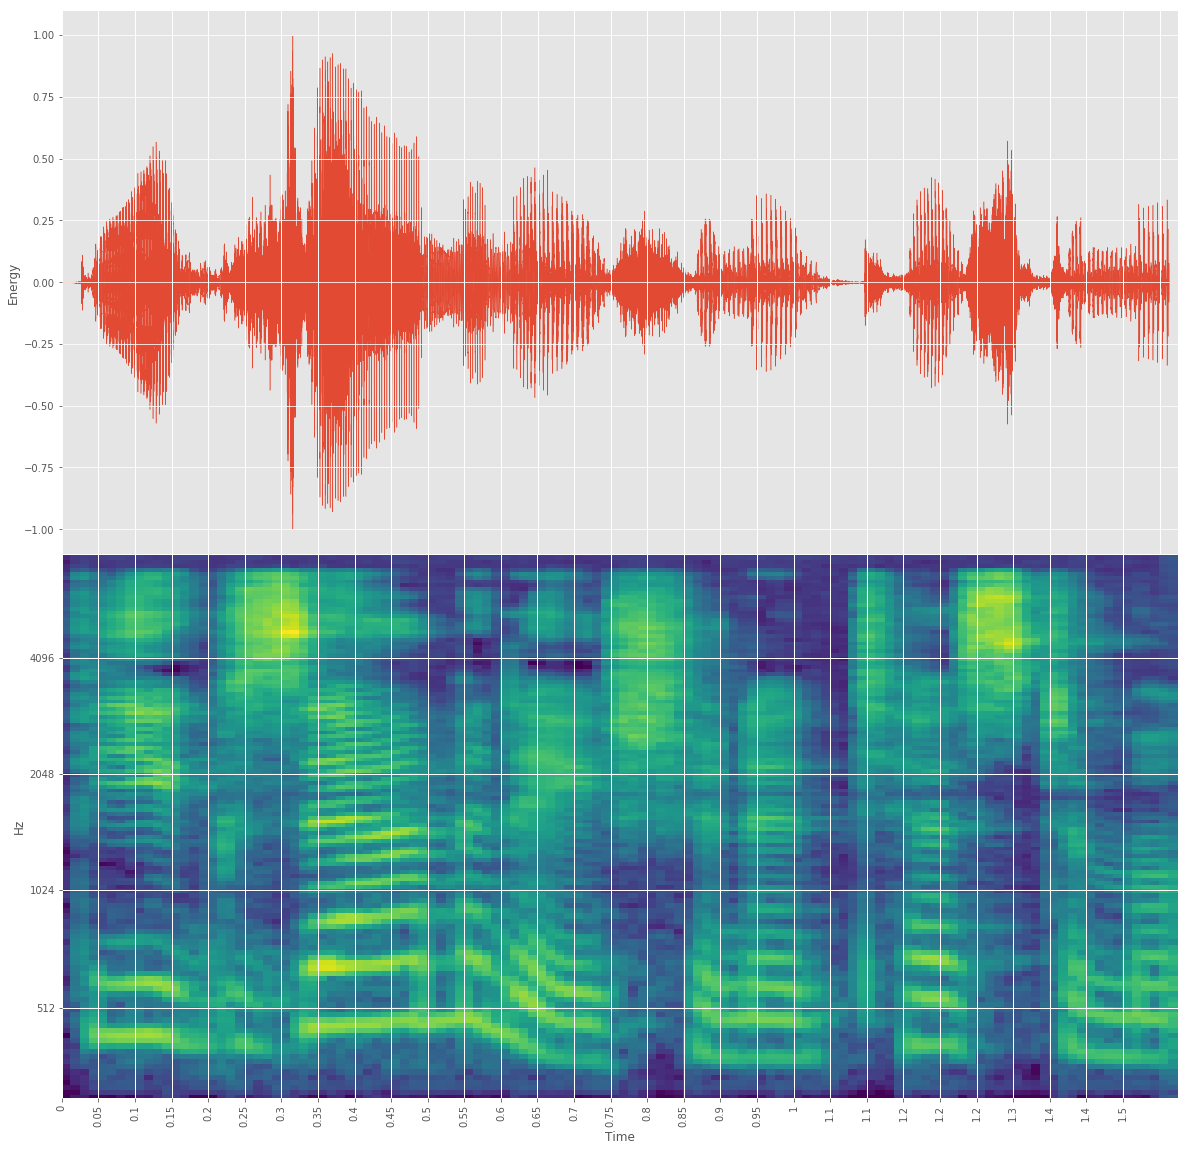

In [42]:
import matplotlib.gridspec as gridspec

pyplot.style.use('ggplot')
pyplot.rcParams['axes.axisbelow'] = False

pyplot.figure(figsize = (20,20))

gridspec = gridspec.GridSpec(2, 1)
gridspec.update(wspace=0, hspace=0)  # Set the spacing between axes. 

grid_offset = 0  # Offset a frame hop
pyplot.subplot(gridspec[0])
plot_waveform(padded_signal, grid_offset=grid_offset)

pyplot.subplot(gridspec[1])
plot_log_mel_spectrogram(log_mel_spectrogram, grid_offset=grid_offset)
pyplot.show()

## Padding Alignment

Here we check if the frames align with the padded signal.

In [18]:
import numpy as np

signal = np.arange(1, 25)
frame_size = 8
frame_hop = 4
n_fft = 16
print('Signal', signal)
print('Frame Size', frame_size)
print('Hop Length', frame_hop)

Signal [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Frame Size 8
Hop Length 4


In [19]:
import librosa 

def print_get_frames(frames_signal, target_signal, center=True):
    """ Print frame and signal alignment.
    
    Args:
        frames_signal (np.ndarray): Signal used to build the spectrogram.
        target_signal (np.ndarray): Corresponding aligned signal used by the vocoder.
        center (bool): Similar to Librosa's frame signal padding implementation. 
    """
    if center:
        frames_signal = np.pad(frames_signal, (n_fft - frame_hop) // 2, mode='constant', constant_values=0)
        print('Centered Frame Signal (%d): %s' % (len(frames_signal), frames_signal))
        
    # NOTE: Does not apply a window equal to ``frame_size`` centered in ``n_fft``.
    frames = librosa.util.frame(frames_signal, frame_length=n_fft, hop_length=frame_hop)

    # Borrowed this from librosa.core.stft
    print('\nUpsampling Mapping...')
    for bl_s in range(0, frames.shape[1]):
        bl_t = min(bl_s + 1, frames.shape[1])
        print('Signal frame was computed from → Signal frame is aligned with', 
              frames[:, bl_s:bl_t].reshape((-1)), ' → ',
              target_signal[bl_s * frame_hop:(bl_s + 1) * frame_hop])
    print('Frames', frames.shape[1])

Test the padding strategy implemented in ``src.audio.get_log_mel_spectrogram``.

In [20]:
import math

# Borrowed this from src.audio.get_log_mel_spectrogram
remainder = frame_hop - signal.shape[0] % frame_hop
padding = (math.ceil(remainder / 2), math.floor(remainder / 2))
frame_signal = np.pad(signal, padding, mode='constant', constant_values=0)
print('Remainder', remainder)
print('Frame Signal (%d)' % len(frame_signal), frame_signal)

# Borrowed this from src.audio.get_log_mel_spectrogram
target_signal = frame_signal
print('Target Signal (%d)' % len(target_signal), target_signal)

print_get_frames(frame_signal, target_signal)

Remainder 4
Frame Signal (28) [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24  0  0]
Target Signal (28) [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24  0  0]
Centered Frame Signal (40): [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
 17 18 19 20 21 22 23 24  0  0  0  0  0  0  0  0]

Upsampling Mapping...
Signal frame was computed from → Signal frame is aligned with [0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 8]  →  [0 0 1 2]
Signal frame was computed from → Signal frame is aligned with [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]  →  [3 4 5 6]
Signal frame was computed from → Signal frame is aligned with [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]  →  [ 7  8  9 10]
Signal frame was computed from → Signal frame is aligned with [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]  →  [11 12 13 14]
Signal frame was computed from → Signal frame is aligned with [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23